In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
def cart2spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta = np.arccos(z/r)
    if r == 0:
        theta = 0
    return (r, theta, phi)

def S(theta, phi):
    S = np.array([[np.sin(theta)*np.cos(phi), np.cos(theta)*np.cos(phi), -np.sin(phi)],
                  [np.sin(theta)*np.sin(phi), np.cos(theta)*np.sin(phi),  np.cos(phi)],
                  [np.cos(theta),             -np.sin(theta),             0]])
    return S

def computeB(r, theta, phi, a=1, muR=100, B0=1):
    delta = (muR - 1)/(muR + 2)
    if r > a:
        Bspherical = B0*np.array([np.cos(theta) * (1 + 2*delta*a**3 / r**3),
                                  np.sin(theta) * (delta*a**3 / r**3 - 1),
                                  0])
        B = np.dot(S(theta, phi), Bspherical)
    else:
        B = 3*B0*(muR / (muR + 2)) * np.array([0, 0, 1])
    return B


xx = np.linspace(-2.5,2.5,400)
zz = np.linspace(-2.5,2.5,400)

X,Z = np.meshgrid(xx,zz)

Bx = np.zeros(np.shape(X))
Bz = np.zeros(np.shape(X))
Babs = np.zeros(np.shape(X))
for i in range(len(X)):
    for j in range(len(Z)):
        r, theta, phi = cart2spherical(X[0, i], 0, Z[j, 0])
        B = computeB(r, theta, phi)
        Bx[i, j], Bz[i, j] = B[0], B[2]
        Babs[i, j] = np.sqrt(B[0]**2 + B[1]**2 + B[2]**2)

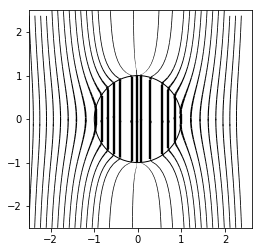

In [18]:
plt.figure(figsize=(4,4),facecolor="w")
plt.streamplot(X, Z, Bx, Bz, color='k', linewidth=0.8*Babs, density=1.3,
               minlength=0.9, arrowstyle='-')
plt.axes().add_patch(Circle((0, 0), radius=1, edgecolor="k",facecolor='w', linewidth=1))
plt.axes().set_aspect("equal","datalim")
plt.savefig('streamlines.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [19]:
from scipy import interpolate
from scipy.integrate import ode

# interpolate function of the Bx and Bz as functions of (x,z) position
fbx = interpolate.interp2d(xx,zz,Bx)
fbz = interpolate.interp2d(xx,zz,Bz)
def B_dir(t,p,fx,fz):
    ex = fx(p[0],p[1])
    ez = fz(p[0],p[1])
    n = (ex**2+ez**2)**0.5
    return [ex/n,ez/n]

In [20]:
# set the starting point of the magnetic field line
xstart = np.linspace(-2.5,2.5,50)
ystart = np.linspace(-2.5,-2.5,50)
places=np.vstack([xstart,ystart]).T

In [21]:
R=0.01
dt=0.8*R

# plot area
x0, x1=-2.5, 2.5
y0, y1=-2.5, 2.5

# set the ode function
r=ode(B_dir)
r.set_integrator('vode')
r.set_f_params(fbx,fbz)

xs,ys = [],[]
for p in places:
    x=[p[0]]
    y=[p[1]]
    r.set_initial_value([x[0], y[0]], 0)
    while r.successful():
        r.integrate(r.t+dt)
        x.append(r.y[0])
        y.append(r.y[1])
        hit_electrode=False
        # check if field line left drwaing area
        if (not (x0<r.y[0] and r.y[0]<x1)) or (not (y0<r.y[1] and r.y[1]<y1)):
            break
    xs.append(x)
    ys.append(y)

/home/yasunobu/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


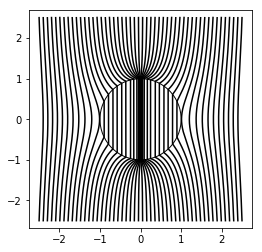

In [22]:
plt.figure(figsize=(4,4),facecolor="w")

for x,y in zip(xs,ys):
    plt.plot(x,y,color="k")
plt.axes().add_patch(Circle((0, 0), radius=1, edgecolor="k",facecolor='w', linewidth=1))
plt.axes().set_aspect("equal","datalim")
plt.savefig('streamlines_continuous.png', bbox_inches='tight', pad_inches=0)
plt.show()